In [42]:
import glob
import json
import re
from collections import Counter, defaultdict
from itertools import combinations
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import chisquare, chi2_contingency
from statsmodels.stats.inter_rater import aggregate_raters, fleiss_kappa
from scipy.stats import bootstrap


# Load Data

In [2]:
def get_bug_id(bug):
    # build bug_id identyfier
    
    bug_id = ""
    
    if 'cve' in bug:
        bug_id = bug['cve']['id']
        
    if not bug_id or "<missing" in bug_id:
        bug_id = bug['projectName']
        
    return bug_id


def to_user(x):
    x = x.replace("auto_", "")
    if x[0:3] in ['A_1', 'A_4', 'A_7']:
        return 'E1'#'PP'
    elif x[0:3] in ['A_2', 'A_5']:
        return 'E2'#'MF'
    elif x[0:3] in ['A_3', 'A_6']:
        return 'E3'#'JN'
    elif x[0:3] in ['A_7']:
         return 'E*1'#'PP'
    elif x[0] == 'B':
        return 'U1'#'RW'
    elif x[0] == 'C':
        return 'U2' #'AK'
    elif x[0] == 'D':
        return 'U3' #'ŁH'
    else:
        return 'auto'

In [3]:
bug_count = Counter()

reviewer_count = Counter()

bugs2 = defaultdict(dict)

for fjson in glob.glob("2023-10-23_113026/*.json"):
    
    with open(fjson) as f:
        data = json.load(f)
    
        if not data:
            continue
            
        for bug in data:
            # Do not count model annotations (example annotations shown to users)
            if not 'datasetName' in bug['data']: 
                continue
                
            # get user id
            user_id = fjson.split("/")[1].split(".")[0]
            
            # Count number of Tasks done by rev
            reviewer_count[user_id] += 1

            bug_id = get_bug_id(bug['data'])
                
            bug_count[bug_id] += 1
            
            
            if 'datasetName' in bug['data']: 
                ds = bug['data']['datasetName'] + "_"
    
            bugs2[ds + bug_id][user_id] =  bug

        
df_bug_count = pd.DataFrame.from_dict(bug_count, orient='index')

In [4]:
rdf = pd.DataFrame.from_dict(reviewer_count, orient='index')
rdf['u'] = rdf.index.map(to_user)
rdf.groupby('u').sum().T.to_dict()

{'E1': {0: 199},
 'E2': {0: 211},
 'E3': {0: 188},
 'U1': {0: 594},
 'U2': {0: 596},
 'U3': {0: 594}}

In [5]:
ab = len(df_bug_count.index.unique())

ab3 = len(df_bug_count[df_bug_count[0] >= 3].index.unique())
ab2 = len(df_bug_count[df_bug_count[0] >= 2].index.unique())
ab1 = len(df_bug_count[df_bug_count[0] >= 1].index.unique())

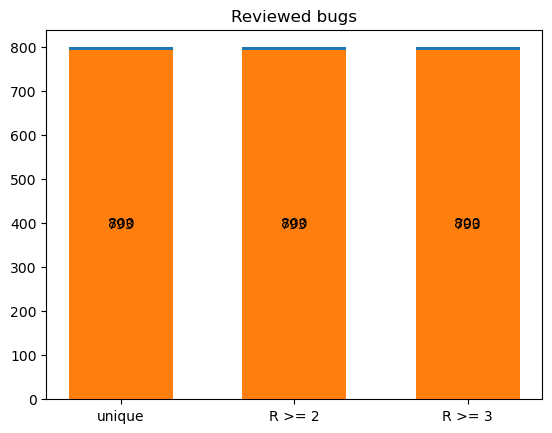

In [6]:
labels = ('unique', 'R >= 2', 'R >= 3')
bugs_count = {
    'all': np.array([800, 800, 800]),
    'reviewd': np.array([ab, ab2, ab3]),

}
width = 0.6  # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots()

for rtype, r_count in bugs_count.items():
    p = ax.bar(labels, r_count, width, label=labels)
    ax.bar_label(p, label_type='center')

ax.set_title('Reviewed bugs')
plt.show()


In [7]:
# Oznaczenia kategorii dla plików 

files_categories = defaultdict(lambda: defaultdict(list))
#lines_categories = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
lines_categories_an = defaultdict(lambda: defaultdict(lambda : defaultdict(lambda: defaultdict(lambda: defaultdict(list)))))

anwsers = defaultdict(lambda: defaultdict(list))

records = []
records_initial = []


def extract_annotated_lines(files, user, fid):
    #enum_files = defaultdict(lambda: defaultdict(Counter))
    ret = []
    for id, file in enumerate(files):
        fname = file['fileName']            
        fcat = file['category']

        for image in file['lines']:
            for line in file['lines'][image]:
                #enum_files[fname][image][line['lineNumber']] += 1
                #lid = enum_files[fname][image][line['lineNumber']] 
                ret.append((bug, user, fname, fid, fcat, image, line['lineNumber'], line['category']))
    return ret
    

for bug in bugs2:
    if len(bugs2[bug]) > 0:
        for user in bugs2[bug]:
            
            anotation = bugs2[bug][user]

            for fid, files in enumerate(bugs2[bug][user]["data"]['initialAnnotation']['diffsFiles']):
                records_initial.extend(extract_annotated_lines(files, "auto_"+ user, fid))

            for res in anotation['annotations']: 
                # 0 bug type, 1 rev is sure, 2 - problematic
                for fid, files in enumerate(res['result'][3]['value']['diffsFiles']):
                    records.extend(extract_annotated_lines(files, user, fid))



In [8]:
records.extend(records_initial)
df = pd.DataFrame(records)
df_initial = pd.DataFrame(records_initial)

df.columns = ['id', 'bundle', 'file', 'fileid', 'fcat', 'image', 'line', 'annotation']

df['user'] = df['bundle'].apply(to_user)
df['auto'] = df['bundle'].apply(lambda x: 'auto' in x)

df['ds'] = df['id'].apply(lambda x: x.split("_")[0])
df['bug'] = df['id'].apply(lambda x: x.split("_")[1])

In [9]:
df

,id,bundle,file,fileid,fcat,image,line,annotation,user,auto,ds,bug
0,cve_CVE-2020-10289,B_6_13,actionlib_tools/scripts/library.py,0,programming,afterChange,103,bug(fix),U1,False,cve,CVE-2020-10289
1,cve_CVE-2020-10289,B_6_13,actionlib_tools/scripts/library.py,0,programming,afterChange,137,bug(fix),U1,False,cve,CVE-2020-10289
2,cve_CVE-2020-10289,B_6_13,actionlib_tools/scripts/library.py,0,programming,beforeChange,103,bug(fix),U1,False,cve,CVE-2020-10289
3,cve_CVE-2020-10289,B_6_13,actionlib_tools/scripts/library.py,0,programming,beforeChange,137,bug(fix),U1,False,cve,CVE-2020-10289
4,cve_CVE-2020-10289,C_4_9,actionlib_tools/scripts/library.py,0,programming,afterChange,103,bug(fix),U2,False,cve,CVE-2020-10289
...,...,...,...,...,...,...,...,...,...,...,...,...
407713,cve_CVE-2018-16876,auto_C_5_8,lib/ansible/plugins/connection/ssh.py,0,programming,afterChange,361,bug(fix),U2,True,cve,CVE-2018-16876
407714,cve_CVE-2018-16876,auto_C_5_8,lib/ansible/plugins/connection/ssh.py,0,programming,afterChange,362,bug(fix),U2,True,cve,CVE-2018-16876
407715,cve_CVE-2018-16876,auto_C_5_8,lib/ansible/plugins/connection/ssh.py,0,programming,afterChange,363,bug(fix),U2,True,cve,CVE-2018-16876
407716,cve_CVE-2018-16876,auto_C_5_8,lib/ansible/plugins/connection/ssh.py,0,programming,afterChange,364,bug(fix),U2,True,cve,CVE-2018-16876


# Analysis friendly ds

In [10]:
users = df['user'].unique()

display(df)

files = df\
    .groupby(['id', 'ds', 'file', 'fileid', 'fcat']).count().reset_index()\
    .groupby(['ds', 'fcat']).count().reset_index()

display(users, files)


#files.to_dict()
df.to_csv("collective.csv")
df.to_json("collective.json")

,id,bundle,file,fileid,fcat,image,line,annotation,user,auto,ds,bug
0,cve_CVE-2020-10289,B_6_13,actionlib_tools/scripts/library.py,0,programming,afterChange,103,bug(fix),U1,False,cve,CVE-2020-10289
1,cve_CVE-2020-10289,B_6_13,actionlib_tools/scripts/library.py,0,programming,afterChange,137,bug(fix),U1,False,cve,CVE-2020-10289
2,cve_CVE-2020-10289,B_6_13,actionlib_tools/scripts/library.py,0,programming,beforeChange,103,bug(fix),U1,False,cve,CVE-2020-10289
3,cve_CVE-2020-10289,B_6_13,actionlib_tools/scripts/library.py,0,programming,beforeChange,137,bug(fix),U1,False,cve,CVE-2020-10289
4,cve_CVE-2020-10289,C_4_9,actionlib_tools/scripts/library.py,0,programming,afterChange,103,bug(fix),U2,False,cve,CVE-2020-10289
...,...,...,...,...,...,...,...,...,...,...,...,...
407713,cve_CVE-2018-16876,auto_C_5_8,lib/ansible/plugins/connection/ssh.py,0,programming,afterChange,361,bug(fix),U2,True,cve,CVE-2018-16876
407714,cve_CVE-2018-16876,auto_C_5_8,lib/ansible/plugins/connection/ssh.py,0,programming,afterChange,362,bug(fix),U2,True,cve,CVE-2018-16876
407715,cve_CVE-2018-16876,auto_C_5_8,lib/ansible/plugins/connection/ssh.py,0,programming,afterChange,363,bug(fix),U2,True,cve,CVE-2018-16876
407716,cve_CVE-2018-16876,auto_C_5_8,lib/ansible/plugins/connection/ssh.py,0,programming,afterChange,364,bug(fix),U2,True,cve,CVE-2018-16876


array(['U1', 'U2', 'U3', 'E2', 'E3', 'E1'], dtype=object)

,ds,fcat,id,file,fileid,bundle,image,line,annotation,user,auto,bug
0,bugs-in-py,data,11,11,11,11,11,11,11,11,11,11
1,bugs-in-py,documentation,180,180,180,180,180,180,180,180,180,180
2,bugs-in-py,other,4,4,4,4,4,4,4,4,4,4
3,bugs-in-py,programming,607,607,607,607,607,607,607,607,607,607
4,bugs-in-py,project,5,5,5,5,5,5,5,5,5,5
5,bugs-in-py,test,600,600,600,600,600,600,600,600,600,600
6,crawl,data,55,55,55,55,55,55,55,55,55,55
7,crawl,documentation,542,542,542,542,542,542,542,542,542,542
8,crawl,markup,13,13,13,13,13,13,13,13,13,13
9,crawl,other,40,40,40,40,40,40,40,40,40,40


# Analysis

## Flow

In [11]:
ret_df = [] 
per_line_match = []

ret_flow = []

users = df['user'].unique()

def get_stats(z, u1, u2):
    
    z['match'] = (z['annotation_x'] == z['annotation_y'])

    out = z.groupby(['ds', 'id', 'file', 'fileid']).agg(All=('match', 'count'), Match=('match', 'sum'))
    
    flow = z.reset_index().groupby(
        ['ds', 'id','annotation_y', 'annotation_x', 'user_x','file', 'fileid',  'line', 'image']
    ).agg(Count=('match', 'count'))
    
    out['u1'] = u1
    out['u2'] = u2
    
    return out, flow

for u in users:
    
    cond1 = (df['user'] == u) & ~(df['auto'])
    cond2 = (df['user'] == u) & (df['auto'])
    
    z = df[cond1].merge(df[cond2], how='inner', on=['id','file', 'fileid', 'image','line','ds'])
    
    out, flow_auto = get_stats(z, u, 'AUTO')
    
    ret_flow.append(flow_auto)
    ret_df.append(out)
    

    
for u1, u2 in combinations(users,2):
    
    cond1 = (df['user'] == u1) & ~(df['auto'])
    cond2 = (df['user'] == u2) & ~(df['auto'])

    z = df[cond1].merge(df[cond2], how='inner', on=['id','file','fileid', 'image','line','ds'])

    out, flow = get_stats(z, u1, u2)
    
    ret_df.append(out)

ret_df = pd.concat(ret_df)

In [12]:
flow_auto

Count
ds         id                     annotation_y annotation_x           user_x file                    fileid line image              
bugs-in-py bugs-in-py_PySnooper-1 bug(fix)     bug(fix)               E1     pysnooper/pycompat.py   0      11   afterChange       1
                                                                             pysnooper/tracer.py     0      17   afterChange       1
                                                                                                            18   afterChange       1
                                                                                                            87   beforeChange      1
                                                                                                            89   afterChange       1
...                                                                                                                              ...
cve        cve_CVE-2022-31015     bug(fix)     bug(fix) + refactoring E1     src/waitress/channel.py 0      379  afterChange       1
                                  test         test                   E1     tests/test_channel.py   0      379  afterChange       1
                                                                                                                 beforeChange      1
                                                                                                            456  afterChange       1
                                                                                                                 beforeChange      1

[16047 rows x 1 columns]

In [13]:
flow_auto = pd.concat(ret_flow)
tmp = flow_auto.reset_index().groupby(['annotation_y', 'annotation_x']).sum().reset_index()
S = tmp['Count'].sum()
tmp['S'] = (tmp['Count'] / S) * 100
#tmp
tmp['auto'] = "A: " + tmp['annotation_y']
tmp['user'] = "U: " + tmp['annotation_x']

print(tmp[['auto', 'user', 'S']].to_csv(index=False))

auto,user,S
A: bug(fix),U: bug(fix),26.403257057366396
A: bug(fix),U: bug(fix) + refactoring,2.2848453633531998
A: bug(fix),U: documentation,3.2967895420989377
A: bug(fix),U: other,0.8265273587913571
A: bug(fix),U: refactoring,3.303166311039168
A: bug(fix),U: test,0.06082456527604052
A: documentation,U: bug(fix),0.2972555367522625
A: documentation,U: bug(fix) + refactoring,0.006867289627940059
A: documentation,U: documentation,14.887793392686335
A: documentation,U: other,0.11919652711353101
A: documentation,U: refactoring,0.026488117136340226
A: documentation,U: test,0.009319893066490078
A: documentation,U: test + refactoring,0.004414686189390038
A: test,U: bug(fix),0.0941799720403208
A: test,U: bug(fix) + refactoring,0.00833885169107007
A: test,U: documentation,1.4499791528707724
A: test,U: other,0.03924165501680033
A: test,U: refactoring,0.8363377725455571
A: test,U: test,44.620214357540526
A: test,U: test + refactoring,1.4249625977975622



/tmp/ipykernel_232579/783009.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = flow_auto.reset_index().groupby(['annotation_y', 'annotation_x']).sum().reset_index()


# Tangling

/tmp/ipykernel_232579/27409827.py:108: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


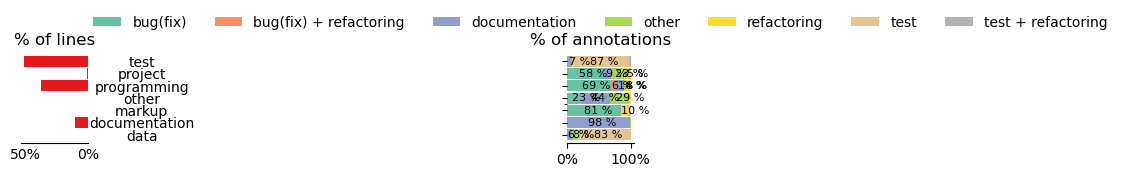

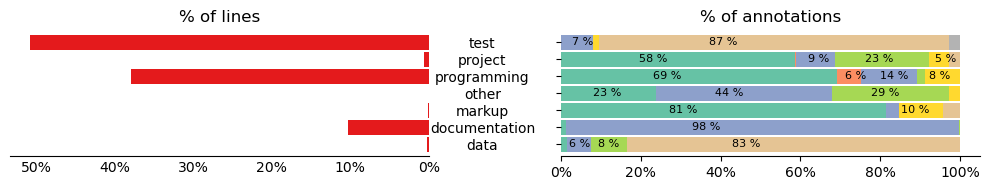

In [14]:


def export_legend(legend, filename="legend.svg"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)



def plot_percentage(df, cols, cols2, legend=True, filename=None):
    
    fig, axes = plt.subplots(figsize=(10,2), ncols=2, sharey=True)


    # plot in groups
    x_var, y_var = cols
    df_grouped = df.groupby(x_var)[y_var].value_counts(normalize=True).unstack(y_var)
    cmap = sns.color_palette("Set2", as_cmap=True)
    ax = df_grouped.plot.barh(stacked=True, width=0.9, ax=axes[1], colormap=cmap)
    
    
    # Plot total count
    x_var2, y_var2 = cols2
    df_grouped2 = df.groupby(x_var).count()[y_var]
    
    df_grouped2 /= df_grouped2.sum()
    cmap = sns.color_palette("Set1", as_cmap=True)

    df_grouped2.plot.barh(stacked=False, width=0.9, ax=axes[0], colormap=cmap)

    if legend and filename:
        legend = plt.legend(
            bbox_to_anchor=(0.5, 1.20),
            loc="lower center",
            borderaxespad=0,
            frameon=False,
            ncol=8,
        )
        export_legend(legend, "legend_" + filename )
    else:
        ax.get_legend().remove()
        
    df_grouped.fillna(0)
    for ix, row in df_grouped.reset_index(drop=True).iterrows():
        #print(ix, row, )
        cumulative = 0
        for element in row:
            if element == element and element >= 0.05:
                #print(">>", element, ix)
                plt.text(
                    cumulative + element/3,
                    ix,
                    f"{int(element * 100)} %",
                    va="center",
                    ha="left",
                    fontsize=8

                )
                cumulative += element
    

    #for ax in axes.flat:
    #    ax.margins(0.1)
        
    #plt.autoscale(enable=True, axis='both', tight=True) # tight layout
    #fig.subplots_adjust(wspace=0.7)

    axes[0].xaxis.set_major_formatter(lambda x,y: str(int(x*100))+'%')
    axes[1].xaxis.set_major_formatter(lambda x,y: str(int(x*100))+'%')

    #ax.tick_params(axis='x', which='major', labelsize=8)
    
    # If you have positive numbers and want to invert the x-axis of the left plot
    axes[0].invert_xaxis() 

    
    #plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)

    #plt.setp(axes[0].yaxis.get_majorticklabels(), ha='center')
    
    #axes[0].set(yticks=y, yticklabels=job_r)

    
    axes[0].yaxis.tick_right()
    plt.setp(axes[0].yaxis.get_majorticklabels(), ha='center')
    axes[0].tick_params(axis=u'both', which=u'both',length=0)
    
    # Create offset transform by some points in x direction
    dx = 35/72.
    dy = 0 / 72.
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    # apply offset transform to all y ticklabels.
    for label in axes[0].yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)

    #fig[0]["right"].major_ticklabels.set_ha("center")

    fig.subplots_adjust(wspace=0.5)

    sns.despine(left=True, right=True)
    axes[0].set_title("% of lines")
    axes[1].set_title("% of annotations")
    axes[0].set(ylabel=None)




    plt.tight_layout()
    fig.tight_layout()
    if filename:
        fig.savefig(filename)

    

plot_percentage(df[~df['auto']], ['fcat', 'annotation'], ['fcat', 'annotation'], legend = True, filename="fcat_annotations.svg")
plot_percentage(df[~df['auto']], ['fcat', 'annotation'], ['fcat', 'annotation'], legend = False, filename="fcat_annotations.svg")


# Consensus

In [15]:
user_l = {}
df_inter_rater = None
users_ids = ['U1', 'U2', 'U3', 'E1', 'E2', 'E3']
cols = ['id', 'file', 'fileid', 'image', 'line', 'annotation']
colsj = cols[:-1]

for user in users_ids:
    filter = (df['user'] == user) & (df['auto'] == False)
    if df_inter_rater is None:
        df_inter_rater = df[filter][cols].copy()
    else:
        df_inter_rater = df_inter_rater.merge(df[filter][cols], left_on = colsj, right_on = colsj, suffixes=('', "_"+user), how='outer')

    #df_inter_rater = df_inter_rater.drop_duplicates(subset=['id', 'file', 'image', 'line', 'annotation'])
    
    #tmp_g_debug = df_inter_rater.groupby(colsj).count().reset_index()
    #display(tmp_g_debug[tmp_g_debug['annotation'] > 1])


In [16]:
filter = (df['auto'] == False)
len(df[filter])/3, len(df[~filter])/3, 

(67955.0, 67951.0)

In [17]:
df_inter_rater.columns = [ c if c != 'annotation' else 'annotation_U1' for c in df_inter_rater.columns]

In [18]:
possible_line_annotations = df['annotation'].unique().tolist()
possible_line_annotations

['bug(fix)',
 'bug(fix) + refactoring',
 'documentation',
 'refactoring',
 'other',
 'test + refactoring',
 'test']

In [19]:
df_inter_rater

,id,file,fileid,image,line,annotation_U1,annotation_U2,annotation_U3,annotation_E1,annotation_E2,annotation_E3
0,cve_CVE-2020-10289,actionlib_tools/scripts/library.py,0,afterChange,103,bug(fix),bug(fix),bug(fix),NaN,NaN,NaN
1,cve_CVE-2020-10289,actionlib_tools/scripts/library.py,0,afterChange,137,bug(fix),bug(fix),bug(fix),NaN,NaN,NaN
2,cve_CVE-2020-10289,actionlib_tools/scripts/library.py,0,beforeChange,103,bug(fix),bug(fix),bug(fix),NaN,NaN,NaN
3,cve_CVE-2020-10289,actionlib_tools/scripts/library.py,0,beforeChange,137,bug(fix),bug(fix),bug(fix),NaN,NaN,NaN
4,cve_CVE-2016-10516,werkzeug/debug/tbtools.py,0,afterChange,353,bug(fix),bug(fix) + refactoring,NaN,NaN,bug(fix),NaN
...,...,...,...,...,...,...,...,...,...,...,...
67958,bugs-in-py_pandas-88,pandas/tests/reshape/test_pivot.py,0,beforeChange,900,NaN,test,test,test,NaN,NaN
67959,bugs-in-py_pandas-88,pandas/tests/reshape/test_pivot.py,0,beforeChange,901,NaN,test,test,test,NaN,NaN
67960,bugs-in-py_pandas-88,pandas/tests/reshape/test_pivot.py,0,beforeChange,902,NaN,test,test,test,NaN,NaN
67961,bugs-in-py_pandas-88,pandas/tests/reshape/test_pivot.py,0,beforeChange,903,NaN,test,test,test,NaN,NaN


In [20]:
def consensus(row):
    ret = {k:0 for k in possible_line_annotations}
    val = None
    for u in users_ids:
        u_val = row['annotation_' + u]
        if not pd.isnull(u_val):
            ret[u_val] += 1
            val = u_val
            
    if sum(ret.values()) < 3: # Check if all 3 reviewers annotated line
        print("Error")

    return Counter(ret).most_common(1)[0][0]

In [21]:
tmp = pd.DataFrame(df_inter_rater.apply(consensus, axis=1).tolist())
G = df_inter_rater.copy()
G['consensus']= tmp

In [22]:
G

,id,file,fileid,image,line,annotation_U1,annotation_U2,annotation_U3,annotation_E1,annotation_E2,annotation_E3,consensus
0,cve_CVE-2020-10289,actionlib_tools/scripts/library.py,0,afterChange,103,bug(fix),bug(fix),bug(fix),NaN,NaN,NaN,bug(fix)
1,cve_CVE-2020-10289,actionlib_tools/scripts/library.py,0,afterChange,137,bug(fix),bug(fix),bug(fix),NaN,NaN,NaN,bug(fix)
2,cve_CVE-2020-10289,actionlib_tools/scripts/library.py,0,beforeChange,103,bug(fix),bug(fix),bug(fix),NaN,NaN,NaN,bug(fix)
3,cve_CVE-2020-10289,actionlib_tools/scripts/library.py,0,beforeChange,137,bug(fix),bug(fix),bug(fix),NaN,NaN,NaN,bug(fix)
4,cve_CVE-2016-10516,werkzeug/debug/tbtools.py,0,afterChange,353,bug(fix),bug(fix) + refactoring,NaN,NaN,bug(fix),NaN,bug(fix)
...,...,...,...,...,...,...,...,...,...,...,...,...
67958,bugs-in-py_pandas-88,pandas/tests/reshape/test_pivot.py,0,beforeChange,900,NaN,test,test,test,NaN,NaN,test
67959,bugs-in-py_pandas-88,pandas/tests/reshape/test_pivot.py,0,beforeChange,901,NaN,test,test,test,NaN,NaN,test
67960,bugs-in-py_pandas-88,pandas/tests/reshape/test_pivot.py,0,beforeChange,902,NaN,test,test,test,NaN,NaN,test
67961,bugs-in-py_pandas-88,pandas/tests/reshape/test_pivot.py,0,beforeChange,903,NaN,test,test,test,NaN,NaN,test


## Consensus vs Auto

In [23]:
Z = df[df['auto'] == True].groupby(cols).count().reset_index()

In [24]:
Z

,id,file,fileid,image,line,annotation,bundle,fcat,user,auto,ds,bug
0,bugs-in-py_PySnooper-1,pysnooper/pycompat.py,0,afterChange,11,bug(fix),3,3,3,3,3,3
1,bugs-in-py_PySnooper-1,pysnooper/tracer.py,0,afterChange,17,bug(fix),3,3,3,3,3,3
2,bugs-in-py_PySnooper-1,pysnooper/tracer.py,0,afterChange,18,bug(fix),3,3,3,3,3,3
3,bugs-in-py_PySnooper-1,pysnooper/tracer.py,0,afterChange,89,bug(fix),3,3,3,3,3,3
4,bugs-in-py_PySnooper-1,pysnooper/tracer.py,0,afterChange,135,bug(fix),3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
67946,cve_CVE-2022-31124,tests/fuzzer/fuzz_valid_magic.py,1,afterChange,27,test,3,3,3,3,3,3
67947,cve_CVE-2022-31124,tests/fuzzer/requirements.txt,1,afterChange,1,test,3,3,3,3,3,3
67948,cve_CVE-2022-31124,tests/fuzzer/requirements.txt,1,afterChange,2,test,3,3,3,3,3,3
67949,cve_CVE-2022-31124,tests/fuzzer/requirements.txt,1,afterChange,3,test,3,3,3,3,3,3


In [25]:
R = Z.merge(G, left_on=colsj, right_on=colsj)
#R = R[['consensus', 'annotation']]


In [26]:
R

,id,file,fileid,image,line,annotation,bundle,fcat,user,auto,ds,bug,annotation_U1,annotation_U2,annotation_U3,annotation_E1,annotation_E2,annotation_E3,consensus
0,bugs-in-py_PySnooper-1,pysnooper/pycompat.py,0,afterChange,11,bug(fix),3,3,3,3,3,3,other,NaN,bug(fix),bug(fix),NaN,NaN,bug(fix)
1,bugs-in-py_PySnooper-1,pysnooper/tracer.py,0,afterChange,17,bug(fix),3,3,3,3,3,3,bug(fix) + refactoring,NaN,bug(fix),bug(fix),NaN,NaN,bug(fix)
2,bugs-in-py_PySnooper-1,pysnooper/tracer.py,0,afterChange,18,bug(fix),3,3,3,3,3,3,bug(fix) + refactoring,NaN,bug(fix),bug(fix),NaN,NaN,bug(fix)
3,bugs-in-py_PySnooper-1,pysnooper/tracer.py,0,afterChange,89,bug(fix),3,3,3,3,3,3,bug(fix),NaN,bug(fix),bug(fix),NaN,NaN,bug(fix)
4,bugs-in-py_PySnooper-1,pysnooper/tracer.py,0,afterChange,135,bug(fix),3,3,3,3,3,3,bug(fix) + refactoring,NaN,bug(fix) + refactoring,bug(fix),NaN,NaN,bug(fix) + refactoring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67958,cve_CVE-2022-31124,tests/fuzzer/fuzz_valid_magic.py,1,afterChange,27,test,3,3,3,3,3,3,test,test,NaN,NaN,test,NaN,test
67959,cve_CVE-2022-31124,tests/fuzzer/requirements.txt,1,afterChange,1,test,3,3,3,3,3,3,other,bug(fix),NaN,NaN,other,NaN,other
67960,cve_CVE-2022-31124,tests/fuzzer/requirements.txt,1,afterChange,2,test,3,3,3,3,3,3,other,bug(fix),NaN,NaN,other,NaN,other
67961,cve_CVE-2022-31124,tests/fuzzer/requirements.txt,1,afterChange,3,test,3,3,3,3,3,3,other,bug(fix),NaN,NaN,other,NaN,other


In [27]:
def users_vs_auto(row):
    ret = Counter()
    for u in users_ids:
        u_val = row['annotation_' + u]
        if not pd.isnull(u_val):
            ret[u_val] += 1
            val = u_val
            
    if sum(ret.values()) < 3: # Check if all 3 reviewers annotated line
        print("Error")

    if ret.most_common(1)[0][1] > 1:
        consensus_type =  "%dxU" % (ret.most_common(1)[0][1])
    else:
        return "other"
    
    if ret.most_common(1)[0][0] == row["annotation"]:
        consensus_type += " == A"
    else:
        consensus_type += " != A"
    
    return consensus_type

In [28]:
R['UvsA'] = R.apply(users_vs_auto, axis=1)
R['ds'] = R['id'].map(lambda x: x.split("_")[0])

In [29]:
cuser_vs_auto = R.groupby(['ds', 'UvsA']).count().reset_index()

In [30]:
cuser_vs_auto

,ds,UvsA,id,file,fileid,image,line,annotation,bundle,fcat,user,auto,bug,annotation_U1,annotation_U2,annotation_U3,annotation_E1,annotation_E2,annotation_E3,consensus
0,bugs-in-py,2xU != A,706,706,706,706,706,706,706,706,706,706,706,529,581,541,263,107,97,706
1,bugs-in-py,2xU == A,2133,2133,2133,2133,2133,2133,2133,2133,2133,2133,2133,1568,1676,1630,579,435,511,2133
2,bugs-in-py,3xU != A,693,693,693,693,693,693,693,693,693,693,693,543,478,612,128,195,123,693
3,bugs-in-py,3xU == A,16331,16331,16331,16331,16331,16331,16331,16331,16331,16331,16331,12016,12684,12510,3216,4434,4133,16331
4,bugs-in-py,other,358,358,358,358,358,358,358,358,358,358,358,218,304,296,162,27,67,358
5,crawl,2xU != A,911,911,911,911,911,911,911,911,911,911,911,568,730,730,380,183,142,911
6,crawl,2xU == A,2942,2942,2942,2942,2942,2942,2942,2942,2942,2942,2942,2397,1993,2041,412,1297,686,2942
7,crawl,3xU != A,1523,1523,1523,1523,1523,1523,1523,1523,1523,1523,1523,1316,1235,746,374,661,237,1523
8,crawl,3xU == A,20458,20458,20458,20458,20458,20458,20458,20458,20458,20458,20458,14676,15164,15936,6061,5151,4386,20458
9,crawl,other,268,268,268,268,268,268,268,268,268,268,268,223,190,179,27,77,108,268


,id,file,fileid,image,line,annotation,bundle,fcat,user,auto,bug,annotation_U1,annotation_U2,annotation_U3,annotation_E1,annotation_E2,annotation_E3,consensus,sort
ds,,,,,,,,,,,,,,,,,,,
bugs-in-py,20221,20221,20221,20221,20221,20221,20221,20221,20221,20221,20221,14874,15723,15589,4348,5198,4931,20221,10
crawl,26102,26102,26102,26102,26102,26102,26102,26102,26102,26102,26102,19180,19312,19632,7254,7369,5559,26102,10
cve,21640,21640,21640,21640,21640,21640,21640,21640,21640,21640,21640,16826,13875,17828,4457,5224,6710,21640,10


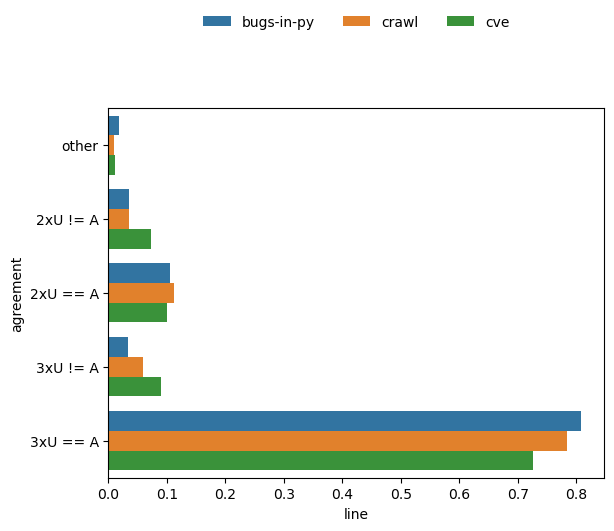

In [31]:
cuser_vs_auto['agreement'] = cuser_vs_auto['UvsA']

cuser_vs_auto['sort'] = cuser_vs_auto['agreement'].map(lambda x: 0 if x[0]== "o" else int(x[0]))

divide_sum = cuser_vs_auto.groupby(['ds']).sum('line')
display(divide_sum)
for ds in divide_sum.index:
    cuser_vs_auto.loc[cuser_vs_auto['ds'] == ds, 'line'] /= divide_sum.loc[ds,'line']


#cuser_vs_auto
sns.barplot(cuser_vs_auto.sort_values('sort', ascending=True), y='agreement', x='line', hue='ds')


legend = plt.legend(
    bbox_to_anchor=(0.5, 1.20),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=3,
)
export_legend(legend, "legend_" + 'automatic_vs_users.svg' )
plt.savefig('automatic_vs_users.svg')

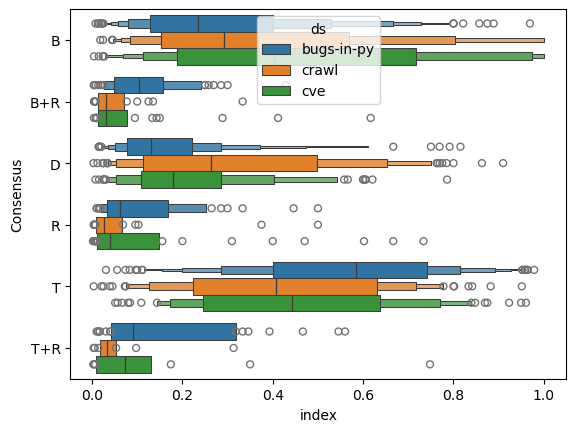

In [32]:
a = G.reset_index().groupby(['id', 'consensus']).count()
b = G.reset_index().groupby(['id']).count()

r = pd.DataFrame(a['index']/b['index']).reset_index()

r['ds'] = r['id'].map(lambda x: x.split("_")[0])
#display(r.groupby(['ds','consensus']).median())

short_names = {"bug(fix)":"B", "bug(fix) + refactoring":"B+R", "documentation":"D", "refactoring":"R", "test":"T", "test + refactoring":"T+R"}
r['Consensus']= r['consensus'].map(short_names)
sns.boxenplot(r, y='Consensus', x='index', hue='ds')
#r.groupby(['ds', 'consensus']).agg(median_bugfix=('index', 'median'), mean_bugfix=('index', 'mean'), std_bugfix=('index', 'std'))

plt.savefig("distribution_of_labels_in_fixes.svg")


In [66]:

types_of_lines_in_commit = list(r['consensus'].unique())
DS = list(r['ds'].unique())

for t in types_of_lines_in_commit:
    for d in DS:
        filter = (r['consensus']==t) & (r['ds']==d)
        print(t, d, bootstrap( ( r[filter]['index'],), np.median, confidence_level=0.99))






bug(fix) bugs-in-py BootstrapResult(confidence_interval=ConfidenceInterval(low=0.21428571428571427, high=0.26969696969696966), bootstrap_distribution=array([0.22886905, 0.25      , 0.25      , ..., 0.25      , 0.21702899,
       0.25      ]), standard_error=0.01136057953047476)
bug(fix) crawl BootstrapResult(confidence_interval=ConfidenceInterval(low=0.20638568588469186, high=0.39803370786516856), bootstrap_distribution=array([0.36738956, 0.27443182, 0.26101514, ..., 0.31109403, 0.35369909,
       0.30170316]), standard_error=0.041637756270771195)
bug(fix) cve BootstrapResult(confidence_interval=ConfidenceInterval(low=0.3, high=0.5), bootstrap_distribution=array([0.34351679, 0.38863636, 0.4037037 , ..., 0.43910256, 0.38867925,
       0.34409722]), standard_error=0.03768749059994093)
bug(fix) + refactoring bugs-in-py BootstrapResult(confidence_interval=ConfidenceInterval(low=0.05714285714285714, high=0.14285714285714285), bootstrap_distribution=array([0.064     , 0.11320755, 0.125     ,

# Table

In [34]:
tmp = flow_auto.reset_index()
tmp['user_x'].unique()
#tmp['match'] = tmp['annotation_y'] == tmp['annotation_x']
tmp['type'] = tmp['user_x'].map(lambda x: x[0])

In [35]:
# Sankey whole data
diag_ret = []

diag_bugs = tmp.groupby(['ds', 'id']).agg(Files = ('id','count')).reset_index().groupby(['ds']).count().reset_index()


diag_bugs = diag_bugs[['ds', 'id']]
diag_bugs.columns = ['Dataset', 'Bugs']

diag_ret.append(diag_bugs)


diag_bugs = tmp.groupby(['ds', 'id', 'file']).count().reset_index().groupby(['ds']).count().reset_index()
diag_bugs = diag_bugs[['ds', 'file',]]
diag_bugs.columns = ['ds', 'Files']

diag_ret.append(diag_bugs)


diag_bugs = tmp.groupby(['ds', 'id', 'file', 'image', 'line']).count().reset_index().groupby(['ds']).sum().reset_index()
diag_bugs = diag_bugs[['ds', 'line',]]
diag_bugs.columns = ['ds', 'Lines']

#diag_ret.append(diag_bugs)

df_inter_rater['ds'] = df_inter_rater['id'].map(lambda x: x.split("_")[0])
diag_bugs = df_inter_rater.groupby('ds').count()[['line']].reset_index()
diag_bugs = diag_bugs[['ds', 'line',]]
diag_bugs.columns = ['ds', 'Lines']


diag_ret.append(diag_bugs)

summary = pd.concat(diag_ret, axis=1)[['Dataset','Bugs', 'Files', 'Lines']]

#diag_bugs
summary

/tmp/ipykernel_232579/2837343866.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diag_bugs = tmp.groupby(['ds', 'id', 'file', 'image', 'line']).count().reset_index().groupby(['ds']).sum().reset_index()


,Dataset,Bugs,Files,Lines
0,bugs-in-py,496,1382,20221
1,crawl,145,759,26102
2,cve,152,601,21640


In [36]:
stats = df[~df['auto']].groupby(['ds', 'annotation']).count()['id'].reset_index().pivot(index='ds', columns='annotation')
stats_org = stats.copy()
S = stats.sum(axis=1)
for c in stats.columns:
    stats[c] /= S 
    stats[c] *= 100
    #stats['S']=S

#stats_style = stats.style.format('{:.2f}\%', decimal='.', precision=2)
stats.columns = [c[1] for c in stats.columns]

In [37]:
# G['ds'] = G['id'].map(lambda x: x.split("_")[0])
# stats = G.groupby(['ds']).count()
# #S = stats.groupby('ds').sum()
# #S
# G

In [38]:
filter = cuser_vs_auto['UvsA'].map(lambda x: x.split("x")[0] == "3")
cuser_vs_auto["UvsA"] == '3xU == A'

#display(cuser_vs_auto)
B_copy = cuser_vs_auto[['ds','UvsA', 'annotation']].pivot(index='ds', columns='UvsA')

B_copy.columns = [pair[1] for pair in B_copy.columns]
B_copy['3xU'] = (B_copy['3xU == A'] + B_copy['3xU != A'])/B_copy.sum(axis=1) * 100
#B_copy['2xU'] = (B_copy['2xU == A'] + B_copy['2xU != A'])/B_copy.sum(axis=1)  * 100
B_copy['2|3xU'] = (B_copy['2xU == A'] + B_copy['2xU != A']
                   + B_copy['3xU == A'] + B_copy['3xU != A'])/B_copy.sum(axis=1)  * 100

display(B_copy)


,2xU != A,2xU == A,3xU != A,3xU == A,other,3xU,2|3xU
ds,,,,,,,
bugs-in-py,706,2133,693,16331,358,84.189704,97.822282
crawl,911,2942,1523,20458,268,84.211938,98.654972
cve,1578,2172,1943,15702,245,81.538817,98.496705


In [39]:
table_paper = summary.merge(stats, left_on='Dataset', right_index=True).merge(B_copy[['3xU', '2|3xU']], right_index=True, left_on='Dataset',)

In [40]:
print(table_paper.to_latex(float_format="{:.1f}%".format))

\begin{tabular}{llrrrrrrrrrrrr}
\toprule
{} &     Dataset &  Bugs &  Files &  Lines &  bug(fix) &  bug(fix) + refactoring &  documentation &  other &  refactoring &  test &  test + refactoring &   3xU &  2|3xU \\
\midrule
0 &  bugs-in-py &   496 &   1382 &  20221 &     24.7\% &                    2.6\% &          13.2\% &   0.5\% &         1.9\% & 55.2\% &                1.9\% & 84.2\% &  97.8\% \\
1 &       crawl &   145 &    759 &  26102 &     26.1\% &                    2.1\% &          29.2\% &   1.2\% &         1.5\% & 38.8\% &                1.2\% & 84.2\% &  98.7\% \\
2 &         cve &   152 &    601 &  21640 &     29.6\% &                    2.2\% &          14.2\% &   1.2\% &         9.5\% & 42.0\% &                1.3\% & 81.5\% &  98.5\% \\
\bottomrule
\end{tabular}



/tmp/ipykernel_232579/4270149668.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_paper.to_latex(float_format="{:.1f}%".format))


# Stat test

## Datasets are diffrent 

In [49]:
S = stats_org.sum(axis=1)

display(chi2_contingency(stats_org))
display(chi2_contingency(stats_org.loc[['cve', 'crawl']]))
display(chi2_contingency(stats_org.loc[['bugs-in-py', 'crawl']]))
display(chi2_contingency(stats_org.loc[['bugs-in-py', 'cve']]))

#display(chisquare(f_obs=stats_org.loc['cve'], f_exp=(stats_org.loc['crawl'] / (100 *  S['crawl'])).round(3)))

#display(chisquare(f_obs=stats.loc['cve'] , f_exp=(stats.loc['bugs-in-py'] / (100 * S['bugs-in-py']).round())))

#display(chisquare(f_obs=stats.loc['crawl'] , f_exp=(stats.loc['bugs-in-py'] / (100 * S['bugs-in-py']).round())))



Chi2ContingencyResult(statistic=15266.30789785402, pvalue=0.0, dof=12, expected_freq=array([[16248.03362519,  1394.72823192, 11906.20210433,   597.27325436,
         2526.2160106 , 27099.78668236,   866.76009124],
       [20981.85196086,  1801.07833125, 15375.04018836,   771.28711647,
         3262.2218527 , 34995.23237437,  1119.288176  ],
       [17395.11441395,  1493.19343683, 12746.75770731,   639.43962917,
         2704.56213671, 29012.98094327,   927.95173276]]))

Chi2ContingencyResult(statistic=8187.467892758226, pvalue=0.0, dof=6, expected_freq=array([[17969.42231159,  1410.12190524, 14520.04021616,   769.65187885,
         3334.70487202, 26124.19672406,   791.86209208],
       [21674.57768841,  1700.87809476, 17513.95978384,   928.34812115,
         4022.29512798, 31510.80327594,   955.13790792]]))

Chi2ContingencyResult(statistic=6321.002413574595, pvalue=0.0, dof=6, expected_freq=array([[15452.48172298,  1410.96035842, 13457.14897981,   531.12859765,
         1021.66971823, 27856.10199719,   909.50862572],
       [19954.51827702,  1822.03964158, 17377.85102019,   685.87140235,
         1319.33028177, 35971.89800281,  1174.49137428]]))

Chi2ContingencyResult(statistic=4823.718012957028, pvalue=0.0, dof=6, expected_freq=array([[16516.48357346,  1465.27708886,  8300.50010752,   531.73041359,
         3519.75590758, 29340.79729052,   964.45561847],
       [17682.51642654,  1568.72291114,  8886.49989248,   569.26958641,
         3768.24409242, 31412.20270948,  1032.54438153]]))

## Fleiss agremment

In [51]:
def fleiss_data_row(row):
    ret = {k:0 for k in possible_line_annotations}
    val = None
    for u in users_ids:
        u_val = row['annotation_' + u]
        if not pd.isnull(u_val):
            ret[u_val] += 1
            val = u_val
            
    if sum(ret.values()) < 3:
        print("error")

    return ret

In [52]:
df_inter_rater_format = pd.DataFrame(df_inter_rater.apply(fleiss_data_row, axis=1).tolist())


In [53]:
# all user agreement
print("all datasets", fleiss_kappa(df_inter_rater_format.to_numpy(), method='fleiss'))

# CVE user agreement
filter = (df_inter_rater['ds'] == 'cve')
print("CVE datasets", fleiss_kappa(df_inter_rater_format[filter].to_numpy(), method='fleiss'))

# CRAWL user agreement
filter = (df_inter_rater['ds'] == 'crawl')
print("CRAWL datasets", fleiss_kappa(df_inter_rater_format[filter].to_numpy(), method='fleiss'))

# CRAWL user agreement
filter = (df_inter_rater['ds'] == 'bugs-in-py')
print("BIP datasets", fleiss_kappa(df_inter_rater_format[filter].to_numpy(), method='fleiss'))


all datasets 0.8323339712332565
CVE datasets 0.8203142050317874
CRAWL datasets 0.8437777759543083
BIP datasets 0.819130695165318


In [54]:
df_inter_rater

,id,file,fileid,image,line,annotation_U1,annotation_U2,annotation_U3,annotation_E1,annotation_E2,annotation_E3,ds
0,cve_CVE-2020-10289,actionlib_tools/scripts/library.py,0,afterChange,103,bug(fix),bug(fix),bug(fix),NaN,NaN,NaN,cve
1,cve_CVE-2020-10289,actionlib_tools/scripts/library.py,0,afterChange,137,bug(fix),bug(fix),bug(fix),NaN,NaN,NaN,cve
2,cve_CVE-2020-10289,actionlib_tools/scripts/library.py,0,beforeChange,103,bug(fix),bug(fix),bug(fix),NaN,NaN,NaN,cve
3,cve_CVE-2020-10289,actionlib_tools/scripts/library.py,0,beforeChange,137,bug(fix),bug(fix),bug(fix),NaN,NaN,NaN,cve
4,cve_CVE-2016-10516,werkzeug/debug/tbtools.py,0,afterChange,353,bug(fix),bug(fix) + refactoring,NaN,NaN,bug(fix),NaN,cve
...,...,...,...,...,...,...,...,...,...,...,...,...
67958,bugs-in-py_pandas-88,pandas/tests/reshape/test_pivot.py,0,beforeChange,900,NaN,test,test,test,NaN,NaN,bugs-in-py
67959,bugs-in-py_pandas-88,pandas/tests/reshape/test_pivot.py,0,beforeChange,901,NaN,test,test,test,NaN,NaN,bugs-in-py
67960,bugs-in-py_pandas-88,pandas/tests/reshape/test_pivot.py,0,beforeChange,902,NaN,test,test,test,NaN,NaN,bugs-in-py
67961,bugs-in-py_pandas-88,pandas/tests/reshape/test_pivot.py,0,beforeChange,903,NaN,test,test,test,NaN,NaN,bugs-in-py


In [55]:
# consensus vs auto agreement
tmp = pd.DataFrame(df_inter_rater.apply(consensus, axis=1).tolist())
G = df_inter_rater.copy()
G['consensus']= tmp

Z = df[df['auto'] == True].groupby(cols).count().reset_index()
R = Z.merge(G, left_on=colsj, right_on=colsj)
#R = R[['consensus', 'annotation']]


#df_inter_rater_format_for_auto = aggregate_raters(R.to_numpy())
#fleiss_kappa(df_inter_rater_format_for_auto[0], method='fleiss')

In [56]:
R['A=C'] = R['consensus'] == R['annotation']

In [57]:

matching_fix = R.groupby(['id']).aggregate(C=('A=C', 'count'), S=('A=C', 'sum')).reset_index()

In [58]:
matching_fix['%'] = matching_fix['S']/matching_fix['C']

In [69]:
matching_fix['ds'] = matching_fix['id'].map(lambda x: x.split("_")[0])
matching_fix

,id,C,S,%,ds
0,bugs-in-py_PySnooper-1,60,56,0.933333,bugs-in-py
1,bugs-in-py_PySnooper-2,27,27,1.000000,bugs-in-py
2,bugs-in-py_PySnooper-3,30,30,1.000000,bugs-in-py
3,bugs-in-py_ansible-1,39,39,1.000000,bugs-in-py
4,bugs-in-py_ansible-10,24,22,0.916667,bugs-in-py
...,...,...,...,...,...
788,cve_CVE-2022-29217,214,211,0.985981,cve
789,cve_CVE-2022-29255,65,57,0.876923,cve
790,cve_CVE-2022-31015,27,26,0.962963,cve
791,cve_CVE-2022-31116,95,78,0.821053,cve


In [68]:
display(DS)
for d in DS:
    filter = (matching_fix['ds']==d)
    #display(matching_fix[filter]['%'],)
    #print(d)
    print(d, bootstrap( (matching_fix[filter]['%'],), np.median, confidence_level=0.90, method='basic'))
    print(matching_fix[filter]['%'].min())


['bugs-in-py', 'crawl', 'cve']

bugs-in-py BootstrapResult(confidence_interval=ConfidenceInterval(low=1.0, high=1.0), bootstrap_distribution=array([1., 1., 1., ..., 1., 1., 1.]), standard_error=0.0)
0.18461538461538463
crawl BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9523241092421776, high=0.9804518055320828), bootstrap_distribution=array([0.95294118, 0.96428571, 0.97849462, ..., 0.94954128, 0.96907216,
       0.97849462]), standard_error=0.00993706493674338)
0.0
cve BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9446079911433172, high=0.9762801769380716), bootstrap_distribution=array([0.95023697, 0.96296296, 0.96138939, ..., 0.97222222, 0.97186701,
       0.97391304]), standard_error=0.010946455124172345)
0.21568627450980393


In [ ]:
matching_fix['ds']

In [ ]:
# Fleiss kappa for annotatons when consensus != automation

In [ ]:


R_inter_rater_format = pd.DataFrame(R[R['annotation'] != R['consensus']].apply(fleiss_data_row, axis=1).tolist())


In [ ]:
print("all datasets", fleiss_kappa(R_inter_rater_format.to_numpy(), method='fleiss'))
